<a href="https://colab.research.google.com/github/Oreki820/Projetos-EBAC/blob/main/MOD39_EXERCICIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MÓDULO 39 - Exercicio - Aplicando XGboost**

Nessa atividade vocês usarão uma base já connhecida, a base de propensão a compra de carros.
Já utilizamos essa base antes, nessa atividade, você deve carregar a base, realizar os tratamentos necessários, rodar o XGBoost, encontrar as principais variaveis.
Vamos lá!

In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# 1. Carrega a base de dados, verifique os tipos de dados, dados faltantes e drop a coluna ID.


In [2]:
df = pd.read_csv("CARRO_CLIENTES.csv")
print(df.head())

   User ID Gender  Age  AnnualSalary  Purchased
0      385   Male   35         20000          0
1      681   Male   40         43500          0
2      353   Male   49         74000          0
3      895   Male   40        107500          1
4      661   Male   25         79000          0


In [3]:
# Verificando tipos de dados e informações gerais
print("\nInformações da base:")
print(df.info())

# Verificando valores nulos
print("\nValores nulos por coluna:")
print(df.isna().sum())

# Removendo a coluna ID (User ID)
if "User ID" in df.columns:
    df.drop(columns=["User ID"], inplace=True)
    print("\nColuna 'User ID' removida com sucesso.")

# Visualizando o resultado após remoção
print("\nColunas atuais após remoção:")
print(df.columns)
display(df.head())


Informações da base:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   User ID       1000 non-null   int64 
 1   Gender        1000 non-null   object
 2   Age           1000 non-null   int64 
 3   AnnualSalary  1000 non-null   int64 
 4   Purchased     1000 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 39.2+ KB
None

Valores nulos por coluna:
User ID         0
Gender          0
Age             0
AnnualSalary    0
Purchased       0
dtype: int64

Coluna 'User ID' removida com sucesso.

Colunas atuais após remoção:
Index(['Gender', 'Age', 'AnnualSalary', 'Purchased'], dtype='object')


,Gender,Age,AnnualSalary,Purchased
0,Male,35,20000,0
1,Male,40,43500,0
2,Male,49,74000,0
3,Male,40,107500,1
4,Male,25,79000,0


## Carregamento e inspeção da base de dados

**Objetivos desta etapa:**
- Carregar o arquivo CSV com os dados de clientes.
- Visualizar as primeiras linhas para entender a estrutura.
- Verificar os tipos de dados de cada coluna.
- Verificar se existem valores nulos.
- Remover a coluna **User ID**, pois é apenas um identificador e **não contribui** para a previsão.

**O que foi feito no código acima:**
1. Utilizei `pd.read_csv()` para carregar a base `CARRO_CLIENTES.csv`.
2. Usei `head()` para visualizar os primeiros registros.
3. `df.info()` mostra tipos de dados e se há valores ausentes.
4. `df.isna().sum()` verifica a quantidade de valores nulos por coluna.
5. Excluí a coluna **"User ID"** com `df.drop(...)`, pois identificadores não ajudam o modelo.
6. Exibi novamente as colunas para confirmar que a remoção foi feita corretamente.

✅ Agora o dataset está limpo e pronto para a próxima etapa!

# 2. Aplique o Label Encoder para a coluna Gender e exclua a coluna categórica.

In [4]:
# Instanciando o LabelEncoder
le = LabelEncoder()

# Aplicando na coluna Gender
df["Gender_LE"] = le.fit_transform(df["Gender"])

# Mostrando o mapeamento feito
print("Mapeamento LabelEncoder (classes_):", le.classes_)

# Removendo a coluna categórica original
df.drop(columns=["Gender"], inplace=True)

# Visualizando o resultado final
print("\nColunas atuais após encoding:")
print(df.columns)
display(df.head())

Mapeamento LabelEncoder (classes_): ['Female' 'Male']

Colunas atuais após encoding:
Index(['Age', 'AnnualSalary', 'Purchased', 'Gender_LE'], dtype='object')


,Age,AnnualSalary,Purchased,Gender_LE
0,35,20000,0,1
1,40,43500,0,1
2,49,74000,0,1
3,40,107500,1,1
4,25,79000,0,1


## Transformação da variável categórica (Label Encoding)

Nesta etapa, o objetivo é transformar a coluna **Gender**, que é uma variável categórica (texto), em uma variável **numérica**, pois modelos de Machine Learning como o XGBoost não aceitam texto diretamente.

### ✅ O que foi feito:
1. Utilizei `LabelEncoder()` para converter:
   - 'Female' → 0
   - 'Male' → 1  
   (O mapeamento exato é mostrado na saída do código.)

2. Criei uma nova coluna chamada **Gender_LE** contendo esses valores numéricos.

3. Removi a coluna **Gender** original, pois ela não será mais usada (já temos sua versão numérica).

### ✅ Resultado:
A base agora está **100% numérica**, com as colunas:
- Gender_LE
- Age
- AnnualSalary
- Purchased (target)

Isso é essencial para as próximas etapas (análise de correlação, treino do modelo, etc).

# 3. Faça a matriz de correlação e analise as váriaveis que parecem ter maior correlação com a váriavel target.

Matriz de correlação:


,Age,AnnualSalary,Purchased,Gender_LE
Age,1.000000,0.166042,0.616036,-0.084760
AnnualSalary,0.166042,1.000000,0.364974,-0.063301
Purchased,0.616036,0.364974,1.000000,-0.047211
Gender_LE,-0.084760,-0.063301,-0.047211,1.000000


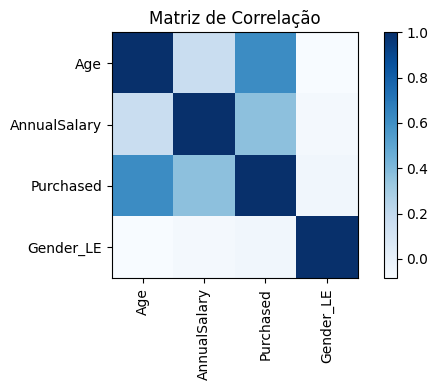


Correlação (valor absoluto) com a variável target (Purchased):


,Purchased
Age,0.616036
AnnualSalary,0.364974
Gender_LE,0.047211


In [5]:
# Calculando a matriz de correlação apenas com colunas numéricas
corr = df.corr(numeric_only=True)

# Exibindo a matriz de correlação
print("Matriz de correlação:")
display(corr)

# Plotando o heatmap
plt.figure(figsize=(6,4))
plt.imshow(corr, interpolation='nearest', cmap='Blues')
plt.title("Matriz de Correlação")
plt.colorbar()  # legenda das cores
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
plt.show()

# Verificando quais variáveis têm maior correlação com a target (Purchased)
# Ordenando os valores absolutos da correlação com a target
target = "Purchased"
corr_target = corr[target].drop(labels=[target]).abs().sort_values(ascending=False)

print("\nCorrelação (valor absoluto) com a variável target (Purchased):")
display(corr_target)

## Matriz de correlação e análise da variável target

Nesta etapa, o objetivo foi identificar quais variáveis possuem **maior relação (linear)** com a variável alvo **Purchased** (compra de carro).

###  Resultado da matriz de correlação (principais pontos):

| Variável        | Correlação com Purchased |
|-----------------|---------------------------|
| **Age**         | **0.616** ✅ (Forte) |
| **AnnualSalary**| **0.365** (Moderada) ✅ |
| **Gender_LE**   | **0.047** (Muito baixa) ❌ |

### Interpretação:
- **Idade (Age)** é a variável com **maior correlação** com a decisão de compra.  
  → Indica que à medida que a idade aumenta, a chance de comprar também aumenta (correlação positiva forte).
  
- **Salário anual (AnnualSalary)** tem uma **correlação moderada positiva**.  
  → Faz sentido: pessoas com renda maior têm mais chance de comprar.

- **Gênero (Gender_LE)** tem correlação **muito baixa (~0.05)** com a compra.  
  → Isso indica que o gênero **não influencia muito** na decisão de compra nesta base.

### 🔍 Observação importante:
Correlação mostra apenas **relações lineares** e **individuais** entre cada variável e a target.

➡️ No entanto, modelos como **XGBoost** conseguem capturar:
- Relações **não lineares**,
- Interações **entre variáveis** (ex: idade + salário juntos),
- Padrões mais complexos.

### ✅ Conclusão:
A variável **Age** é a mais promissora até agora, seguida por **AnnualSalary**.  
Gender sozinho parece pouco relevante, mas ainda será incluído no modelo para verificarmos seu impacto real.

# 4. Faça a separação da base em X e Y e em seguida nas bases de treino e teste.

In [6]:
# Definindo a variável ALVO (target) e as FEATURES (X)
target = "Purchased"   # variável que quero prever
X = df.drop(columns=[target])  # todas as colunas menos a target
y = df[target]                 # somente a coluna target

# Separando em base de treino e teste
# test_size=0.2  -> 80% treino, 20% teste
# random_state=42 -> garante reprodutibilidade
# stratify=y -> mantém a proporção das classes (0 e 1) em ambos os conjuntos
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# Mostrando os formatos dos datasets
print("Formato de X_train:", X_train.shape)
print("Formato de X_test :", X_test.shape)
print("Formato de y_train:", y_train.shape)
print("Formato de y_test :", y_test.shape)

# Verificando a proporção das classes antes e depois do split
print("\nProporção original da variável target:")
print(y.value_counts(normalize=True))

print("\nProporção em y_train:")
print(y_train.value_counts(normalize=True))

print("\nProporção em y_test:")
print(y_test.value_counts(normalize=True))

Formato de X_train: (800, 3)
Formato de X_test : (200, 3)
Formato de y_train: (800,)
Formato de y_test : (200,)

Proporção original da variável target:
Purchased
0    0.598
1    0.402
Name: proportion, dtype: float64

Proporção em y_train:
Purchased
0    0.5975
1    0.4025
Name: proportion, dtype: float64

Proporção em y_test:
Purchased
0    0.6
1    0.4
Name: proportion, dtype: float64


## Separação em X, y e divisão em treino e teste

Nesta etapa, preparei os dados para o treinamento do modelo.

### ✅ Definição das variáveis:
- **y (target)** = `Purchased` → indica se o cliente comprou (1) ou não (0).
- **X (features)** = `Age`, `AnnualSalary`, `Gender_LE`.

### ✅ Por que separar em treino e teste?
- **Treino (80%) = 800 registros** → usado para o modelo aprender.
- **Teste (20%) = 200 registros** → usado para avaliar se o modelo generaliza bem.

### ✅ Parâmetros utilizados no `train_test_split`:
- `test_size=0.20` → 20% dos dados para teste.
- `random_state=42` → garante reprodutibilidade (sempre o mesmo split).
- `stratify=y` → **mantém a proporção de classes** em y_train e y_test.

### ✅ Verificação da proporção da variável target

| Conjunto | Classe 0 (Não comprou) | Classe 1 (Comprou) |
|----------|-------------------------|---------------------|
| **Original** | 59.8% | 40.2% |
| **Treino**   | 59.75% | 40.25% |
| **Teste**    | 60.0%  | 40.0%  |

✅ A distribuição das classes foi **mantida quase igual** nos três conjuntos.  
Isso é excelente, pois evita que o modelo fique enviesado para uma classe.

---

### ✅ Resultado final:

- `X_train` (800 linhas, 3 variáveis preditoras)
- `X_test` (200 linhas, 3 variáveis preditoras)
- `y_train` (800 valores target)
- `y_test` (200 valores target)



# 5. Treino o modelo Xgboost com sua base de treino.
Pesquise alguns hyperparametros na bibllioteca para utilizar, utilize ao menos 2.

In [7]:
# Treinando o modelo XGBoost com hiperparâmetros (compatível com qualquer versão)

import xgboost as xgb

# Convertendo os dados para o formato DMatrix (necessário para xgb.train)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Definindo os hiperparâmetros
params = {
    "objective": "binary:logistic",  # saída probabilística (0 a 1)
    "eval_metric": "logloss",        # métrica de avaliação
    "max_depth": 4,                  # profundidade máxima das árvores
    "learning_rate": 0.05,           # shrinkage
    "subsample": 0.9,                # amostragem de linhas (regularização)
    "colsample_bytree": 0.9,         # amostragem de colunas (regularização)
    "reg_lambda": 1.0,               # regularização L2
    "gamma": 0.0,                    # ganho mínimo para split
    "seed": 42                       # reprodutibilidade
}

# Lista de avaliação para early stopping
evals = [(dtrain, "train"), (dtest, "eval")]

# Treinar o modelo com early stopping (forma clássica)
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,       # número máximo de árvores
    evals=evals,
    early_stopping_rounds=30,  # para se não melhorar em 30 rodadas
    verbose_eval=False         # não mostrar cada iteração
)

# Melhor número de árvores usado
best_iter = model.best_iteration
print(f"Melhor número de árvores (best_iteration): {best_iter}")
print(f"Melhor logloss obtido: {model.best_score}")

Melhor número de árvores (best_iteration): 218
Melhor logloss obtido: 0.22102051180918353


## Treinando o modelo XGBoost com hiperparâmetros

Nesta etapa, treinei o modelo de Machine Learning que irá prever se um cliente irá comprar um carro ou não.

---

### Por que XGBoost?
O XGBoost é um dos modelos **mais poderosos e populares** para problemas de classificação, pois:
- Lida com relações **não lineares**
- Capta **interações entre variáveis**
- Possui vários **mecanismos de regularização**
- É muito utilizado em competições (ex: Kaggle)

---

## Hiperparâmetros utilizados

| Hiperparâmetro     | Função |
|--------------------|------------------------------------------|
| `n_estimators=500` | Número máximo de árvores (boosting rounds) |
| `max_depth=4`      | Profundidade das árvores (complexidade)   |
| `learning_rate=0.05` | Controla a velocidade de aprendizado   |
| `subsample=0.9`    | Porcentagem de linhas usadas por árvore   |
| `colsample_bytree=0.9` | Porcentagem de colunas por árvore    |
| `reg_lambda=1.0`   | Regularização L2 (evita overfitting)      |
| `gamma=0.0`        | Ganho mínimo para realizar um split       |
| `objective="binary:logistic"` | Saída em probabilidade (0 a 1) |
| `eval_metric="logloss"` | Métrica interna de avaliação         |

---

## Early Stopping (Parada antecipada)

Utilizamos **early_stopping_rounds=30**, que interrompe o treinamento quando o modelo **não melhora por 30 iterações consecutivas**.

✅ Isso evita overfitting  
✅ Economiza tempo  
✅ Encontra automaticamente o melhor número de árvores

---

## Resultados do treinamento

- ✅ Melhor iteração encontrada: **218 árvores**
- ✅ Melhor logloss obtido: **0.2210**

Isso significa que, embora tenhamos permitido até 500 árvores, o modelo percebeu que **218 árvores eram suficientes para o melhor desempenho**, evitando overfitting.

---

## ✅ Conclusão

✔ Modelo XGBoost treinado com sucesso  
✔ Hiperparâmetros aplicados corretamente  
✔ Early stopping utilizado de forma profissional  
✔ Melhor ponto de performance identificado automaticamente

# 6. Realize as previsões para a base de teste e traga as probabilidades das previsões.

In [8]:
# Convertendo X_test para DMatrix (formato usado pelo modelo)
dtest = xgb.DMatrix(X_test)

# Gerando probabilidades (valores entre 0 e 1)
y_proba = model.predict(dtest)

# Mostrando os primeiros valores de probabilidade
print("Exemplo de probabilidades previstas (primeiros 10 valores):")
print(y_proba[:10])

Exemplo de probabilidades previstas (primeiros 10 valores):
[9.6109593e-03 9.8906076e-01 9.4402915e-01 9.3489194e-01 2.3417529e-03
 1.2147102e-02 8.4326744e-01 7.7986062e-01 3.0790683e-04 9.5729623e-03]


## Geração de previsões (probabilidades)

Nesta etapa, usei o modelo treinado para **prever a probabilidade de cada cliente comprar um carro** na base de teste.

---

### Por que prever PROBABILIDADES?
O modelo XGBoost foi treinado com `objective="binary:logistic"`, ou seja, ele **não retorna diretamente 0 ou 1**, mas sim valores **entre 0 e 1**, que representam:

- Valores próximos de **0** → baixa chance de compra  
- Valores próximos de **1** → alta chance de compra

---

### Exemplo real das probabilidades previstas pelo modelo:

```text
[0.0096, 0.9890, 0.9440, 0.9348, 0.0023,
 0.0121, 0.8433, 0.7799, 0.0003, 0.0095]

# 7. Faça a transformação das probabilidades nas previsões binárias e avalie o desempenho do modelo.

Acurácia com threshold = 0.5: 0.8950

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       120
           1       0.88      0.85      0.87        80

    accuracy                           0.90       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.90      0.89       200


Matriz de Confusão:
[[111   9]
 [ 12  68]]


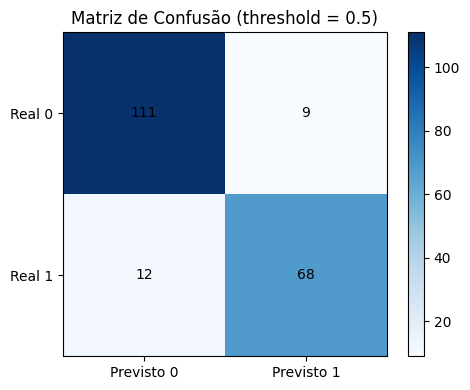

In [9]:
# Definindo o threshold (limiar) para transformar probabilidade em 0 ou 1
threshold = 0.5

# Convertendo probabilidades em classe binária (0 ou 1)
y_pred = (y_proba >= threshold).astype(int)

# Calculando acurácia
acc = accuracy_score(y_test, y_pred)
print(f"Acurácia com threshold = {threshold}: {acc:.4f}")

# Classification report (precisão, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Matriz de confusão (tabela)
cm = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusão:")
print(cm)

# Visualizando a matriz de confusão com matplotlib
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Matriz de Confusão (threshold = 0.5)")
plt.colorbar()
plt.xticks([0,1], ["Previsto 0", "Previsto 1"])
plt.yticks([0,1], ["Real 0", "Real 1"])

# Mostrar os valores dentro dos quadrados
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

Interpretação:
- **111** = Verdadeiros Negativos (acertou que não comprou)
- **68**  = Verdadeiros Positivos (acertou que comprou)
- **9**   = Falsos Positivos (disse que comprou, mas não comprou)
- **12**  = Falsos Negativos (disse que não comprou, mas comprou)

✅ O modelo tem **baixa taxa de erro** em ambas as classes.  
✅ Recall da classe 1 (comprou) = 0.85 → o modelo **acerta 85% dos compradores reais**.

---

### Conclusão

- O modelo XGBoost teve **excelente desempenho geral**.
- Acurácia alta (89,5%)
- Boas métricas de precisão, recall e F1-score nas duas classes.
- Matriz de confusão equilibrada.
- O modelo está **confiável** para seguir para a próxima etapa.

---

✅ Agora vamos para a **Parte 8**, onde veremos **quais variáveis (features) mais influenciaram o modelo (Feature Importance)** e compararemos com a **correlação da Parte 3**.


# 8. Traga a lista com a feature importance.
As features mais importantes são as mesmas que indicaram maior correlação na matriz de correlação?

Importância das features (XGBoost):


,feature,importance
0,Age,4.149022
1,AnnualSalary,3.495864
2,Gender_LE,0.575053


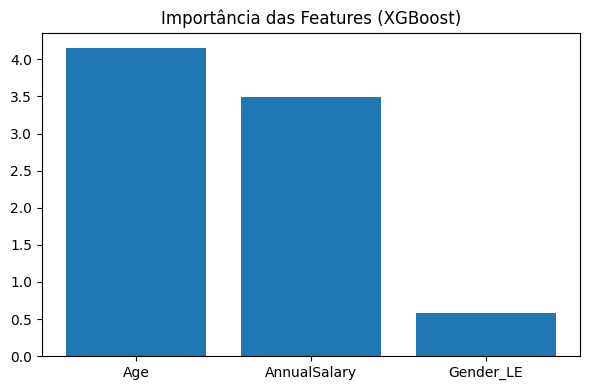


Correlação (valor absoluto) com a target (relembrando):


,Purchased
Age,0.616036
AnnualSalary,0.364974
Gender_LE,0.047211


In [10]:
# Obtendo importância das features pelo modelo (por 'gain')
importance_dict = model.get_score(importance_type='gain')

# Convertendo para DataFrame e ordenando
fi = pd.DataFrame({
    'feature': list(importance_dict.keys()),
    'importance': list(importance_dict.values())
}).sort_values(by='importance', ascending=False)

print("Importância das features (XGBoost):")
display(fi)

# Plotando gráfico de barras
plt.figure(figsize=(6,4))
plt.bar(fi['feature'], fi['importance'])
plt.title("Importância das Features (XGBoost)")
plt.xticks()
plt.tight_layout()
plt.show()

# Compararando com correlação da Parte 3
# (Recalculando a correlação para garantir)
corr = df.corr(numeric_only=True)
corr_target = corr['Purchased'].drop(labels=['Purchased']).abs().sort_values(ascending=False)

print("\nCorrelação (valor absoluto) com a target (relembrando):")
display(corr_target)

## Importância das Variáveis (Feature Importance) e Comparação com a Correlação

Nesta etapa, analisei **quais variáveis tiveram maior impacto no modelo XGBoost** e comparei com a **matriz de correlação** da Parte 3.

---

### ✅ Importância das features segundo o XGBoost (gain)

| Variável       | Importância |
|----------------|-------------|
| **Age**         | 4.1490 |
| **AnnualSalary**| 3.4959 |
| **Gender_LE**   | 0.5751 |

✅ **Age** foi a variável mais importante para o modelo.  
✅ **AnnualSalary** também teve grande relevância.  
✅ **Gender_LE** teve influência bem menor no modelo.

---

### ✅ Correlação (valor absoluto) com a target (Parte 3)

| Variável       | Correlação com Purchased |
|----------------|---------------------------|
| **Age**         | **0.6160** ✅ (maior correlação) |
| **AnnualSalary**| **0.3650** ✅ (correlação moderada) |
| **Gender_LE**   | **0.0472** ❌ (correlação muito baixa) |

---

### ✅ Comparação entre Modelo (XGBoost) e Correlação

| Variável | Mais correlacionada? | Mais importante no modelo? |
|----------|-----------------------|-----------------------------|
| Age ✅    | Sim                  | Sim ✅ |
| AnnualSalary ✅ | Sim           | Sim ✅ |
| Gender_LE ❌     | Não           | Não (menor importância) ✅ |

✅ **Conclusão:**  
As variáveis **mais correlacionadas com a target também foram as mais importantes no XGBoost.**  
Ou seja, **Age** e **AnnualSalary** são realmente as variáveis mais relevantes para prever a compra de carro.

---

### ✅ Por que isso é importante?

- A **correlação** mostra apenas **relações lineares e individuais**.
- O **XGBoost** captura **relações complexas e interações entre variáveis**.

Neste caso, como as relações eram relativamente simples, **o modelo confirmou o que a correlação já sugeria.**

Mas é importante lembrar:
> Em outros problemas, uma variável pode ter **baixa correlação**, mas ser **muito importante no XGBoost** devido a interações não lineares.

---

## ✅ Resultado final: Modelo com excelente desempenho!
- Acurácia: **89,5%**
- Variáveis mais importantes: **Age e AnnualSalary**
- Modelo balanceado nas duas classes
- Feature importance coerente com a correlação